In [1]:
%pylab inline
import pandas
column_names = ["sex", "length", "diameter", "height", "whole weight", 
                "shucked weight", "viscera weight", "shell weight", "rings"]
data = pandas.read_csv("abalone.data", names=column_names)
print("Number of samples: %d" % len(data))
for label in "MFI":
    data[label] = data["sex"] == label
del data["sex"]
import numpy as np
from sklearn import model_selection, tree

Y = data.rings.values
del data["rings"] # remove rings from data, so we can convert all the dataframe to a numpy 2D array.
X = data.values.astype(np.float)

interval = len(Y) / 2
ymap = {}
accum = 0
i = 0
for val in range(Y.min(), Y.max() + 1):
    delta = (Y == val).sum()
    accum += delta
    if accum > interval:
        accum = delta
        i += 1
    ymap[val] = i
mapped_y = zeros(len(Y), dtype=int)
for i, v in enumerate(Y):
    mapped_y[i] = ymap[v]
Y = mapped_y
train_x, test_x, train_y, test_y = model_selection.train_test_split(X, Y) # splits 75%/25% by default
from sklearn.ensemble import RandomForestClassifier

Populating the interactive namespace from numpy and matplotlib
Number of samples: 4177


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:16: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, namedtuple, defaultdict, Sequence


In [5]:
len(X[0])

10

In [10]:
params = {
    "min_samples_leaf": list(range(20, 30, 1)),
    "max_features": list(range(1, 11)),
}
gs = model_selection.GridSearchCV(RandomForestClassifier(n_estimators=20), params, n_jobs=3, verbose=1)
gs = gs.fit(train_x, train_y)
print(gs.score(test_x, test_y))
gs.best_params_
# {'max_features': 8, 'min_samples_leaf': 26}

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=3)]: Done 234 tasks      | elapsed:    5.2s
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed:    7.2s finished


0.7129186602870813


{'max_features': 10, 'min_samples_leaf': 26}

In [11]:
RandomForestClassifier(n_estimators=20, max_features=8, min_samples_leaf=26).fit(train_x, train_y).score(test_x, test_y)

0.7110047846889952

In [12]:
RandomForestClassifier(n_estimators=20, max_features=4, min_samples_leaf=26).fit(train_x, train_y).score(test_x, test_y)

0.7081339712918661

In [2]:
model = RandomForestClassifier(n_estimators=15, max_features=8, min_samples_leaf=26)
model.fit(train_x, train_y)
model.score(test_x, test_y)

0.7129186602870813

In [18]:
len(model.estimators_)

15

In [19]:
type(model.estimators_[0])

sklearn.tree.tree.DecisionTreeClassifier

In [3]:
def tree_to_rules(tree, feature_names):
    from sklearn.tree import _tree as Tree
    
    tree = tree.tree_
    feature_names = [
        feature_names[i] if i != Tree.TREE_UNDEFINED else "TREE_UNDEFINED"
        for i in tree.feature
    ]
    queue = [(0, tuple())]
    rules = []
    while queue:
        node, path = queue.pop()
        if tree.feature[node] != Tree.TREE_UNDEFINED:
            name = feature_names[node]
            threshold = tree.threshold[node]
            queue.append((tree.children_left[node], path + ((name, False, threshold),)))  # <= threshold
            queue.append((tree.children_right[node], path + ((name, True, threshold),)))  # > threshold
        else:
            rules.append((path, tuple(tree.value[node][0])))
    return rules

from copy import deepcopy
from sklearn.tree._tree import TREE_LEAF, TREE_UNDEFINED

def tree_depth(tree):
    max_depth = 0
    stack = [(0,0)]
    while stack:
        node, depth = stack.pop()
        if depth > max_depth:
            max_depth = depth
        if tree.children_left[node] != TREE_LEAF:
            stack.append((tree.children_left[node], depth+1))
        if tree.children_right[node] != TREE_LEAF:
            stack.append((tree.children_right[node], depth+1))
    return max_depth

def get_parents(tree):
    parents = {x:i for i, x in enumerate(tree.children_left) if x != TREE_LEAF}
    parents.update({x:i for i, x in enumerate(tree.children_right) if x != TREE_LEAF})
    return parents

def prune(model, validation_X, validation_y, possible_score_drop=-0.02, verbose=False):
    model = deepcopy(model)
    tree = model.tree_
    curent_score = model.score(validation_X, validation_y)
    changes = True
    while changes:
        changes = False
        leafs = np.where(tree.children_left == TREE_LEAF)[0]
        parents = get_parents(tree)
        for leaf in leafs:
            if leaf not in parents:
                continue
            parent = parents[leaf]
            _child_left = model.tree_.children_left[parent]
            _child_right = model.tree_.children_right[parent]
            _feature = model.tree_.feature[parent]
            model.tree_.children_left[parent] = TREE_LEAF
            model.tree_.children_right[parent] = TREE_LEAF
            model.tree_.feature[parent] = TREE_UNDEFINED
            new_score = model.score(validation_X, validation_y)
            #print(curent_score, new_score, (new_score - curent_score) / curent_score)
            score_change = (new_score - curent_score) / curent_score
            if score_change < possible_score_drop:
                # Bad cut
                model.tree_.children_left[parent] = _child_left
                model.tree_.children_right[parent] = _child_right
                model.tree_.feature[parent] = _feature
            else:
                if verbose:
                    print("Remove {:2} and {:2} leafs. Score change: {:.3f}".format(_child_right, _child_left, score_change))
                changes = True
                break
    return model

In [4]:
from collections import defaultdict

def merge_rules(rules):
    new_rules = []
    for rule, freqs in rules:
        min_vals = {}
        max_vals = {}
        flags = defaultdict(int)
        for name, cmp, val in rule:
            if cmp:
                min_vals[name] = max(min_vals.get(name, val), val)
                flags[name] |= 1
            else:
                max_vals[name] = min(max_vals.get(name, val), val)
                flags[name] |= 2
        new_rule = []
        for key, bits in sorted(flags.items()):
            if bits & 2:
                new_rule.append((key, False, max_vals[key]))
            if bits & 1:
                new_rule.append((key, True, min_vals[key]))
        new_rules.append((new_rule, freqs))
    return new_rules

def compile_rules(rules, feature_names):
    findex = {k: i for i, k in enumerate(feature_names)}
    vals = defaultdict(set)
    for rule, _ in rules:
        for name, _, val in rule:
            vals[name].add(val)
    vals = {findex[name]: sorted(v) for name, v in vals.items()}
    model = {k: ([[] for v in ts] + [[]], ts, set()) for k, ts in vals.items()}
    for ri, (rule, _) in enumerate(rules):
        allnis = set(model)
        names = set()
        for name, cmp, thr in rule:
            ni = findex[name]
            allnis.discard(ni)
            ptrs, vals, _ = model[ni]
            if name not in names:
                for ptr in ptrs:
                    ptr.append(ri)
                names.add(name)
            for ptr, brdr in zip(ptrs, vals + [1<<31]):
                # brdr_{-1} < x <= brdr
                if cmp:
                    # x > thr
                    if brdr <= thr:
                        # x <= brdr <= thr < x - impossible
                        if ptr and ptr[-1] == ri:
                            ptr.pop()
                else:
                    # x <= thr
                    if brdr > thr:
                        # x <= thr < brdr
                        # x <= thr <= brdr_{-1} < x - impossible
                        if ptr and ptr[-1] == ri:
                            ptr.pop()
        for ni in allnis:
            model[ni][2].add(ri)
    return model

def eval_rules(rules, X, Y, feature_names, uncertainty="max"):
    compiled = compile_rules(rules, feature_names)
    matched = 0
    for xi, (x, y) in enumerate(zip(X, Y)):
        ris = set(range(len(rules)))
        for i, v in enumerate(x):
            try:
                ptrs, thrs, skips = compiled[i]
            except KeyError:
                continue
            possible = ptrs[searchsorted(thrs, v)]
            ris = ris.intersection(set(possible).union(skips))
        if len(ris) == 0:
            #print("no rule!")
            continue
        if len(ris) > 1:
            if uncertainty == "max":
                maxfreq = 0
                maxri = -1
                for ri in ris:
                    freqs = rules[ri][1]
                    maxfreqi = argmax(freqs)
                    if freqs[maxfreqi] > maxfreq:
                        maxfreq = freqs[maxfreqi]
                        maxri = ri
                winner = argmax(rules[maxri][1])
            elif uncertainty == "sum":
                allfreqs = zeros_like(rules[next(iter(ris))][1])
                for ri in ris:
                    allfreqs += rules[ri][1]
                winner = argmax(allfreqs)
            elif uncertainty == "conf":
                maxri = -1
                maxconf = -1
                for ri in ris:
                    freqs = rules[ri][1]
                    conf = (max(freqs) - 0.5) / sum(freqs)
                    if conf > maxconf:
                        maxconf = conf
                        maxri = ri
                winner = argmax(rules[maxri][1])
        else:
            winner = argmax(rules[next(iter(ris))][1])
        if winner == y:
            matched += 1
    return matched / len(Y)

In [25]:
trees = [prune(e, test_x, test_y) for e in model.estimators_]

In [5]:
from itertools import chain
rules = list(chain.from_iterable(tree_to_rules(t, data.columns) for t in model.estimators_))

In [34]:
len(rules)

836

In [8]:
eval_rules(rules, test_x, test_y, data.columns, uncertainty="sum")

0.7100478468899522

In [7]:
eval_rules(rules, test_x, test_y, data.columns, uncertainty="max")

0.69377990430622

In [9]:
eval_rules(rules, test_x, test_y, data.columns, uncertainty="conf")

0.6909090909090909

In [45]:
rules0 = list(chain.from_iterable(tree_to_rules(prune(e, test_x, test_y, possible_score_drop=-0.01), data.columns)
                                  for e in model.estimators_))

In [46]:
eval_rules(rules0, test_x, test_y, data.columns, uncertainty="conf")

0.6794258373205742

In [47]:
len(rules0)

102

In [48]:
rules0 = list(chain.from_iterable(tree_to_rules(prune(e, test_x, test_y, possible_score_drop=-0.00), data.columns)
                                  for e in model.estimators_))
print(eval_rules(rules0, test_x, test_y, data.columns, uncertainty="conf"))
print(len(rules0))

0.6909090909090909
130


In [50]:
rules1 = merge_rules(rules0)

In [51]:
rules1[0]

([('shell weight', True, 0.255500003695488),
  ('shucked weight', True, 0.4000000059604645)],
 (53.0, 833.0, 234.0))

In [52]:
print(eval_rules(rules1, test_x, test_y, data.columns, uncertainty="conf"))

0.6909090909090909


In [10]:
rules = merge_rules(rules)

In [13]:
import GPyOpt.methods

def get_domain(rules):
    return [{"name": "r%d" % i, "type": "categorical", "domain": (0, 1)} for i in range(len(rules))]

The set cost function is ignored! LCB acquisition does not make sense with cost.
no rule!
no rule!


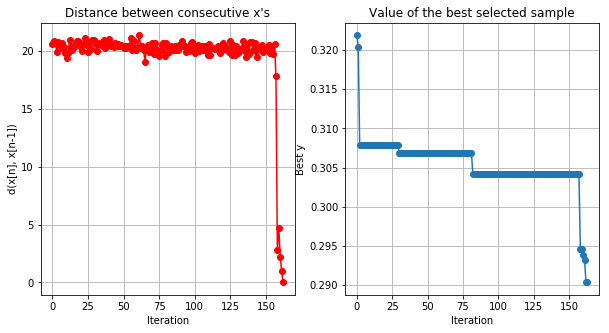

In [67]:
def fit_rules(x):
    new_rules = [r for i, r in enumerate(rules) if x[0][i]]
    return 1 - eval_rules(new_rules, test_x, test_y, data.columns, uncertainty="conf") \
        + len(new_rules) * 0.05 / len(rules)
    
import GPyOpt.methods
opt = GPyOpt.methods.BayesianOptimization(f=fit_rules, domain=get_domain(rules), acquisition_type="LCB",
                                          acquisition_weight=0.2, num_cores=4)
opt.run_optimization(max_iter=300)
opt.plot_convergence()

In [68]:
best_rules = [r for i, r in enumerate(rules) if opt.X[argmin(opt.Y)][i]]
len(best_rules), eval_rules(best_rules, test_x, test_y, data.columns, uncertainty="conf")

(406, 0.7339712918660287)

The set cost function is ignored! LCB acquisition does not make sense with cost.


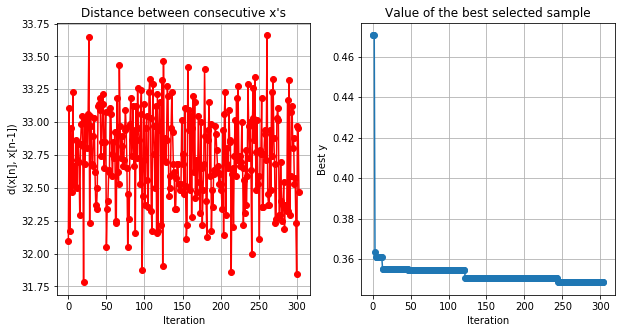

In [78]:
def get_domain_attrbutes(rules):
    domain = []
    imap = {}
    p = 0
    for i, r in enumerate(rules):
        for j in range(len(r[0])):
            imap[p] = (i, j)
            p += 1
            domain.append({"name": "r%d_%d" % (i, j), "type": "categorical", "domain": (0, 1)})
    return domain, imap

domain, imap = get_domain_attrbutes(best_rules)

def fit_rules(x):
    new_rules = []
    prev_i = -1
    rule = []
    for p, flag in enumerate(x[0]):
        if not flag:
            continue
        i, j = imap[p]
        if i != prev_i:
            if rule:
                new_rules.append((tuple(rule), best_rules[prev_i][1]))
                rule.clear()
            prev_i = i
        rule.append(best_rules[i][0][j])
    if rule:
        new_rules.append((rule, best_rules[prev_i][1]))
    # assert x[0].sum() == sum(len(r[0]) for r in new_rules)
    return 1 - eval_rules(new_rules, test_x, test_y, data.columns, uncertainty="conf") \
        + x[0].sum() * 0.05 / len(x[0])
    
import GPyOpt.methods
opt = GPyOpt.methods.BayesianOptimization(f=fit_rules, domain=domain, acquisition_type="LCB",
                                          acquisition_weight=0.2, num_cores=4)
opt.run_optimization(max_iter=300)
opt.plot_convergence()

In [80]:
def extract_best_rules_from_opt(opt):
    x = opt.X[argmin(opt.Y)]
    new_rules = []
    prev_i = -1
    rule = []
    for p, flag in enumerate(x):
        if not flag:
            continue
        i, j = imap[p]
        if i != prev_i:
            if rule:
                new_rules.append((tuple(rule), best_rules[prev_i][1]))
                rule.clear()
            prev_i = i
        rule.append(best_rules[i][0][j])
    if rule:
        new_rules.append((rule, best_rules[prev_i][1]))
    return new_rules

best_rules2 = extract_best_rules_from_opt(opt)

In [81]:
sum(len(r[0]) for r in best_rules2), eval_rules(best_rules2, test_x, test_y, data.columns, uncertainty="conf")

(1073, 0.676555023923445)

In [82]:
sum(len(r[0]) for r in best_rules)

2142

The set cost function is ignored! LCB acquisition does not make sense with cost.


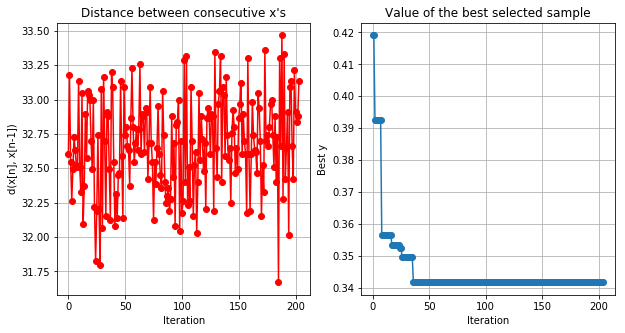

In [85]:
def fit_rules(x):
    new_rules = []
    prev_i = -1
    rule = []
    for p, flag in enumerate(x[0]):
        if not flag:
            continue
        i, j = imap[p]
        if i != prev_i:
            if rule:
                new_rules.append((tuple(rule), best_rules[prev_i][1]))
                rule.clear()
            prev_i = i
        rule.append(best_rules[i][0][j])
    if rule:
        new_rules.append((rule, best_rules[prev_i][1]))
    # assert x[0].sum() == sum(len(r[0]) for r in new_rules)
    return 1 - eval_rules(new_rules, test_x, test_y, data.columns, uncertainty="conf") \
        + x[0].sum() * 0.03 / sum(len(r[0]) for r in best_rules)

opt = GPyOpt.methods.BayesianOptimization(f=fit_rules, domain=domain, acquisition_type="LCB",
                                          acquisition_weight=0.2, num_cores=4)
opt.run_optimization(max_iter=200)
opt.plot_convergence()

In [86]:
best_rules2 = extract_best_rules_from_opt(opt)
sum(len(r[0]) for r in best_rules2), eval_rules(best_rules2, test_x, test_y, data.columns, uncertainty="conf")

(1094, 0.6736842105263158)

The set cost function is ignored! LCB acquisition does not make sense with cost.


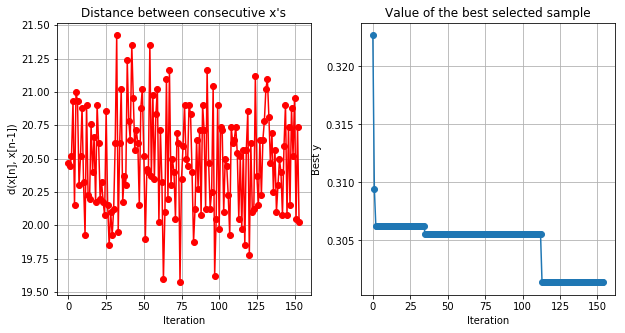

In [98]:
def fit_rules(x):
    new_rules = [r for i, r in enumerate(rules) if x[0][i]]
    return 1 - eval_rules(new_rules, test_x, test_y, data.columns, uncertainty="conf") \
        + len(new_rules) * 0.05 / len(rules)
    
opt = GPyOpt.methods.BayesianOptimization(f=fit_rules,
                                          model_type="sparseGP",
                                          domain=get_domain(rules), acquisition_type="LCB",
                                          acquisition_weight=0.2, num_cores=4)
opt.run_optimization(max_iter=150)
opt.plot_convergence()

In [99]:
best_rules = [r for i, r in enumerate(rules) if opt.X[argmin(opt.Y)][i]]
len(best_rules), eval_rules(best_rules, test_x, test_y, data.columns, uncertainty="conf")

(399, 0.722488038277512)

The set cost function is ignored! LCB acquisition does not make sense with cost.


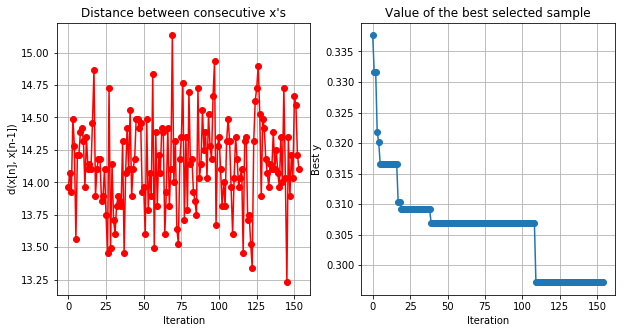

In [100]:
def fit_rules(x):
    new_rules = [r for i, r in enumerate(best_rules) if x[0][i]]
    return 1 - eval_rules(new_rules, test_x, test_y, data.columns, uncertainty="conf") \
        + len(new_rules) * 0.05 / len(best_rules)
    
opt = GPyOpt.methods.BayesianOptimization(f=fit_rules,
                                          model_type="sparseGP",
                                          domain=get_domain(best_rules), acquisition_type="LCB",
                                          acquisition_weight=0.2, num_cores=4)
opt.run_optimization(max_iter=150)
opt.plot_convergence()

In [102]:
best_rules2 = [r for i, r in enumerate(best_rules) if opt.X[argmin(opt.Y)][i]]
len(best_rules2), eval_rules(best_rules2, test_x, test_y, data.columns, uncertainty="conf")

(195, 0.7272727272727273)

The set cost function is ignored! LCB acquisition does not make sense with cost.


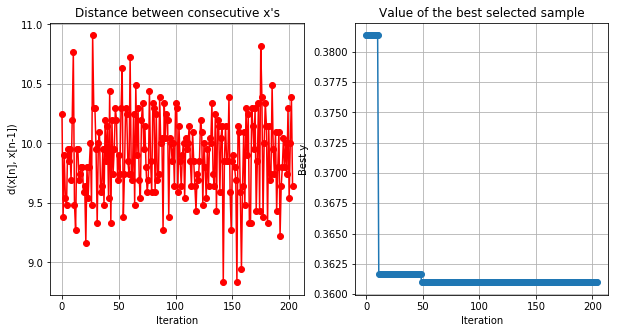

In [104]:
def fit_rules(x):
    new_rules = [r for i, r in enumerate(best_rules2) if x[0][i]]
    return 1 - eval_rules(new_rules, test_x, test_y, data.columns, uncertainty="conf") \
        + len(new_rules) * 0.025 / len(best_rules2)
    
opt = GPyOpt.methods.BayesianOptimization(f=fit_rules,
                                          model_type="GP",
                                          domain=get_domain(best_rules2), acquisition_type="LCB",
                                          acquisition_weight=0.1, num_cores=4)
opt.run_optimization(max_iter=300)
opt.plot_convergence()

In [105]:
best_rules3 = [r for i, r in enumerate(best_rules2) if opt.X[argmin(opt.Y)][i]]
len(best_rules3), eval_rules(best_rules3, test_x, test_y, data.columns, uncertainty="conf")

(109, 0.6669856459330143)

In [14]:
def fit_rules(x):
    new_rules = [r for i, r in enumerate(rules) if x[0][i]]
    return 1 - eval_rules(new_rules, test_x, test_y, data.columns, uncertainty="conf") \
        + len(new_rules) * 0.05 / len(rules)
    
opt = GPyOpt.methods.BayesianOptimization(f=fit_rules,
                                          model_type="sparseGP",
                                          domain=get_domain(rules), acquisition_type="LCB",
                                          acquisition_weight=0.5, num_cores=4)
opt.run_optimization(max_iter=150)
opt.plot_convergence()

> /usr/local/lib/python3.7/dist-packages/GPyOpt/acquisitions/LCB.py(30)__init__()
-> print('The set cost function is ignored! LCB acquisition does not make sense with cost.')
(Pdb) p cost_withGradients
<function constant_cost_withGradients at 0x7fa9d2018ea0>
(Pdb) up
> /usr/local/lib/python3.7/dist-packages/GPyOpt/util/arguments_manager.py(69)acquisition_creator()
-> return AcquisitionLCB(model, space, acquisition_optimizer, cost_withGradients, acquisition_weight)
(Pdb) p cost_withGradients
<function constant_cost_withGradients at 0x7fa9d2018ea0>
(Pdb) up
> /usr/local/lib/python3.7/dist-packages/GPyOpt/methods/bayesian_optimization.py(178)_acquisition_chooser()
-> return self.problem_config.acquisition_creator(self.acquisition_type, self.model, self.space, self.acquisition_optimizer, self.cost.cost_withGradients)
(Pdb) q


BdbQuit: 